Notebook for testing new algorithms

In [4]:
from itertools import product, combinations
from math import asin, sqrt
from multiprocessing import Pool
from typing import Sequence
from random import choice

import re
import pennylane as qml
from pennylane import numpy as qmlnp
import np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
from my_favorite_things import bar_count
from scipy.optimize import minimize

from scripts.constants import EVT_DIR, TOP_MASS
from scripts.qc_utilities import calc_Jij
from scripts.pennylane_algs import VQA, QAOA, MAQAOA, XQAOA
from scripts.new_qc_utilities import get_event

# Load in 4-momentum

In [7]:
p4, Jij, Pij, invm = get_event()

In [8]:
df barrier(func):
    """
    Add barrier in quantum circuit sketch.
    """

    def wrapper(self, *args, **kwargs):
        output = func(self, *args, **kwargs)
        if self.BARRIER:
            qml.Barrier()

        return output

    return wrapper


class ADAPT_QAOA:
    BARRIER = True

    def __init__(
        self,
        Jij,
        depth,
        steps,
        init_beta=0.5,
        init_gamma=0.5,
        prec=1e-6,
        device="default.qubit",
    ):
        # Default value for gamma when finding gradient
        self.gamma0 = 0.01
        # Initial values when optimizing
        self.init_beta = init_beta
        self.init_gamma = init_gamma

        # Make sure to normalize Jij
        self.Jij = Jij
        # Depth of circuit
        self.depth = depth
        # Max number of steps when optimizing
        self.steps = steps
        # Normalized difference between costs of two subsequent steps to stop optimizing at
        self.prec = prec
        self.N = len(Jij)

        self.device = qml.device(device, wires=self.N)

        self.bit_strs = np.array(["".join(bs) for bs in product(["0", "1"], repeat=self.N)])
        # Fully connected weight graph with N vertices
        self.vertices = np.arange(self.N)
        self.edges = np.array(list(combinations(range(self.N), r=2)))
        self.weights = np.array([self.Jij[edge[0], edge[1]] for edge in self.edges])

        # Cost Hamiltonian to take expectation value of
        self.expval_op = qml.Hamiltonian(
            self.weights,
            [qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1]) for edge in self.edges],
        )
        # Single-qubit mixers
        self.mixer_pool = ["QAOAX", "QAOAY"] + [f"X{ind}" for ind in range(self.N)] + [f"Y{ind}" for ind in range(self.N)]
        # Add 2-qubit mixers
        for mixer in [[f"{r1}{i1}{r2}{i2}" for r1, r2 in product(["X", "Y", "Z"], repeat=2)] for i1, i2 in combinations(range(self.N), r=2)]:
            self.mixer_pool += mixer
        # Currently set mixers
        self.mixers = []

    def mixer_op(self, mtype: str, beta: float):
        """
        Creates a mixer layer with parameter `beta`.

        Parameters:
        mtype - Mixer layer. Options are:
            Ai (e.g. X3) - An 'A' rotation gate on qubit i where A ∈ [X, Y]
            AiBj (e.g. X3Y1) - A 'AB' rotation gate on qubits i and j where A ∈ [X, Y, Z]
            QAOAX - An X rotation on every qubit
            QAOAY - A Y rotation on every qubit
        beta - The parameter for this mixer layer
        """
        # Identity
        if mtype.lower() == "i":
            return

        # Single qubit X or Y rotations
        info = re.findall(r"^([xy])(\d+)$", mtype.lower())
        if info:
            rot, qb = info[0]
            qml.PauliRot(beta, rot.upper(), wires=int(qb))
            return

        # A X gate on every qubit OR Y gate
        info = re.findall(r"^qaoa([xy])", mtype.lower())
        if info:
            rot = info[0]
            for ind in range(self.N):
                qml.PauliRot(beta, rot.upper(), wires=ind)
            return

        # A 2-qubit rotation gate
        info = re.findall("^([xyz])(\d+)([xyz])(\d+)$", mtype.lower())
        if info:
            rot1, qb1, rot2, qb2 = info[0]
            qml.PauliRot(beta, f"{rot1.upper()}{rot2.upper()}", wires=[int(qb1), int(qb2)])
            return

    @barrier
    def cost_layer(self, gamma: float = None):
        """
        Cost layer, ZZ gates, weighted by the product of the weights
        from the Jij matrix and the gamma parameter.

        Parameters:
        gamma (default None) - Parameter for this cost layer. If not given,
            will default to self.gamma0
        """
        gamma = self.gamma0 if gamma is None else gamma
        for weight, edge in zip(self.weights, self.edges):
            qml.PauliRot(weight * gamma, "ZZ", wires=edge)

    @barrier
    def mixer_layer(self, mixer: str, beta: float):
        """
        Mixer layer determined by `mixer`.

        Parameters:
        mixer - String representing mixer opeator to use
        beta - Parameter for this mixer layer.
        """
        self.mixer_op(mixer, beta)

    def circuit(self, betas: Sequence[float], gammas: Sequence[float]):
        """
        Base circuit consisting of alternating layers of cost and mixer.

        Parameters:
        betas - The mixer parameters, one for each layer
        gammas - The cost parameters, one for each layer
        """
        for ind in range(self.N):
            qml.Hadamard(wires=ind)

        for mixer, beta, gamma in zip(self.mixers, betas, gammas):
            self.cost_layer(gamma)
            self.mixer_layer(mixer, beta)

    def grad_circuit(self, beta: float):
        """
        Circuit for taking the gradient. A normal circuit but we are varying
        the last beta parameter and setting the last gamma parameter to gamma0.

        Parameters:
        beta - The parameter we are taking the gradient with respect to.
        """
        self.circuit(self.betas, self.gammas)
        self.cost_layer(self.gamma0)
        self.mixer_layer(self.mixers[-1], beta)
        return qml.expval(self.expval_op)

    def cost_circuit(self, betas: Sequence[float], gammas: Sequence[float]):
        """
        Circuit for finding the expectation value of the cost Hamiltonian.

        Parameters:
        betas - The mixer parameters, one for each layer
        gammas - The cost parameters, one for each layer
        """
        self.circuit(betas, gammas)

        return qml.expval(self.expval_op)

    def probs_circuit(self, betas, gammas):
        """
        Circuit returning the probabilities of the states. Same as `cost_circuit`
        but with a different return.

        Parameters:
        betas - The mixer parameters, one for each layer
        gammas - The cost parameters, one for each layer
        """
        self.circuit(betas, gammas)
        return qml.probs()

    def get_probs(self, as_dict=False):
        """
        Use `probs_circuit` to return the probabilities.

        Parameters:
        as_dict (default False) - If True, return probabilities as a dictionary
            with the state bit strings as the keys. Otherwise, reteurn as is
        """
        probs_qnode = qml.QNode(self.probs_circuit, self.device)
        probs = probs_qnode(self.betas, self.gammas).numpy()
        if as_dict:
            return dict(zip(self.bit_strs, probs))
        return probs

    def run(self, print_it=True):
        """
        Run the algorithm.

        Parameters:
        print_it (default True) - If True, print out progress
        """
        # Gradients for each mixer in the mixer pool per depth
        self.grads = [{} for _ in range(self.depth)]
        # Betas and gammas per depth
        self.params = [{} for _ in range(self.depth)]
        # Cost per step per depth
        self.all_costs = []
        # Total number of evaluations per depth
        self.all_evals = []

        # Arrays to store parameters
        self.betas = qmlnp.array([])
        self.gammas = qmlnp.array([])

        # Iterate for each layer
        for p in range(self.depth):
            # Reset optimizer each time
            self.optimizer = qml.AdamOptimizer()
            # Add new place for mixer choices
            self.mixers.append("")

            # Go through mixer pool and find best mixer
            max_grad, max_mixer = 0, ""
            for mixer in self.mixer_pool:
                self.mixers[-1] = mixer
                self.grad_qnode = qml.QNode(self.grad_circuit, self.device)

                # Calculate gradient at beta_k=0
                grad = qml.grad(self.grad_qnode, 0)(0.0)
                self.grads[p][mixer] = grad
                if grad > max_grad:
                    max_grad = grad
                    max_mixer = mixer

            # If change is so small, just don't do anything, i.e. identity
            if qmlnp.round(max_grad, 9) == 0:
                max_grad = 0
                max_mixer = "I"

            if print_it:
                print(f"(p = {p + 1:>{len(str(self.depth))}}) Mixer: {max_mixer:>5} [{max_grad:.4f}]")

            # Save the best mixer in array
            self.mixers[-1] = max_mixer

            # Update betas and gammas with another pair of parameters for optimizing new circuit
            self.betas = qmlnp.concatenate((self.betas, [self.init_beta]))
            self.gammas = qmlnp.concatenate((self.gammas, [self.init_gamma]))

            costs = qmlnp.empty(self.steps)
            self.cost_qnode = qml.QNode(self.cost_circuit, self.device)
            # Optimize as usual
            for ind in range(self.steps):
                (self.betas, self.gammas), costs[ind] = self.optimizer.step_and_cost(self.cost_qnode, self.betas, self.gammas)
                if ind:
                    # Stop optimizing if it slows down enough
                    current_prec = abs(1 - costs[ind - 1] / costs[ind])
                    if current_prec < self.prec:
                        costs = costs[: ind + 1]
                        self.all_evals.append(ind + 1)
                        break

            if print_it:
                print(f"Precision ({ind} steps): {current_prec:3e}")

            # Save data
            self.all_costs.append(costs.numpy())
            self.params[p]["betas"] = self.betas.numpy()
            self.params[p]["gammas"] = self.gammas.numpy()
        self.costs = self.all_costs[-1]
        self.evals = self.all_evals[-1]


# Running Algorithm

In [9]:
adapt = ADAPT_QAOA(Jij=norm_Jij, depth=5, steps=1000, prec=1e-6, device="default.qubit")
adapt.run()

(p = 1) Mixer: QAOAX [0.0237]
Precision (301 steps): 9.309201e-07
(p = 2) Mixer:  Y0Y5 [0.1496]
Precision (199 steps): 8.611123e-07
(p = 3) Mixer:  Y2Y5 [0.1218]
Precision (264 steps): 9.981668e-07
(p = 4) Mixer:  Y1Y3 [0.0998]
Precision (173 steps): 9.899067e-07
(p = 5) Mixer:  Z0Y1 [0.0990]
Precision (344 steps): 9.626136e-07


# Plot Probabilities and Cost

Text(0.538, 0.74, '$p=5$')

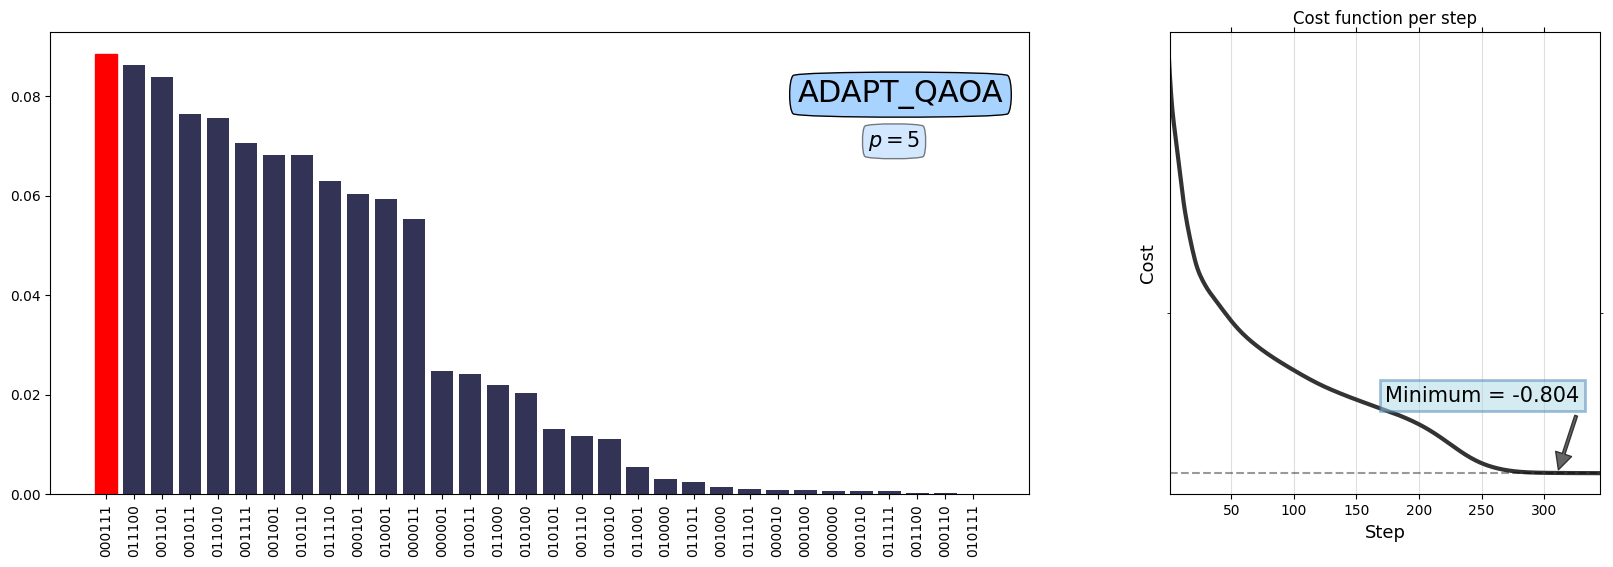

In [18]:
swap = lambda bit_str: bit_str.replace("0", "2").replace("1", "0").replace("2", "1")

alg = adapt
sym = True
fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={"width_ratios": [25, 11]})

probs = alg.get_probs(as_dict=True)
probs_plot = probs
if sym:
    probs_plot = {k: v + probs[swap(k)] for k, v in probs.items() if k.startswith("0")}
bar = bar_count(
    ax=axes[0],
    counts=probs_plot,
    sort_type="desc",
    bar_params={"color": "#333355"},
    x_rot=90,
)
red_inds = np.unique(
    np.append(
        np.where(bar.datavalues == probs_plot["000111"]),
        np.where(bar.datavalues == probs_plot.get("111000")),
    )
).numpy()
for ind in red_inds:
    bar[ind].set_color("r")

cost_min, cost_max = alg.costs.min(), alg.costs.max()

axes[1].plot(alg.costs, lw=3, c="#333333")
axes[1].set_ylabel("Cost", fontsize=13)
axes[1].set_xlabel("Step", fontsize=13)
axes[1].set_xlim(1, alg.evals)
axes[1].yaxis.set_minor_locator(MultipleLocator(0.25))
axes[1].yaxis.set_major_locator(MultipleLocator(0.5))
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
axes[1].axhline(cost_min, ls="dashed", c="k", alpha=0.4)
axes[1].annotate(
    f"Minimum = {cost_min:.3f}",
    textcoords="axes fraction",
    xy=(0.9 * alg.evals, cost_min),
    xytext=(0.5, 0.2),
    fontsize=15,
    arrowprops=dict(facecolor="#666666", edgecolor="#333333", shrink=0.05, width=2),
    bbox=dict(fc="lightblue", ec="steelblue", lw=2, alpha=0.5),
)
axes[1].grid(alpha=0.4)
axes[1].tick_params(top=True, right=True, which="both")
axes[1].set_title("Cost function per step")

fig.suptitle(
    f"{alg.__class__.__name__}",
    fontsize=22,
    x=0.55,
    y=0.8,
    bbox=dict(fc="#a9d3ff", ec="k", boxstyle="round4"),
)
axes[0].annotate(
    f"$p={alg.depth}$",
    xy=(0.538, 0.74),
    fontsize=15,
    xycoords="subfigure fraction",
    bbox=dict(fc="#a9d3ff", ec="k", boxstyle="round4", alpha=0.5),
)


# Plot Costs for Each Detph

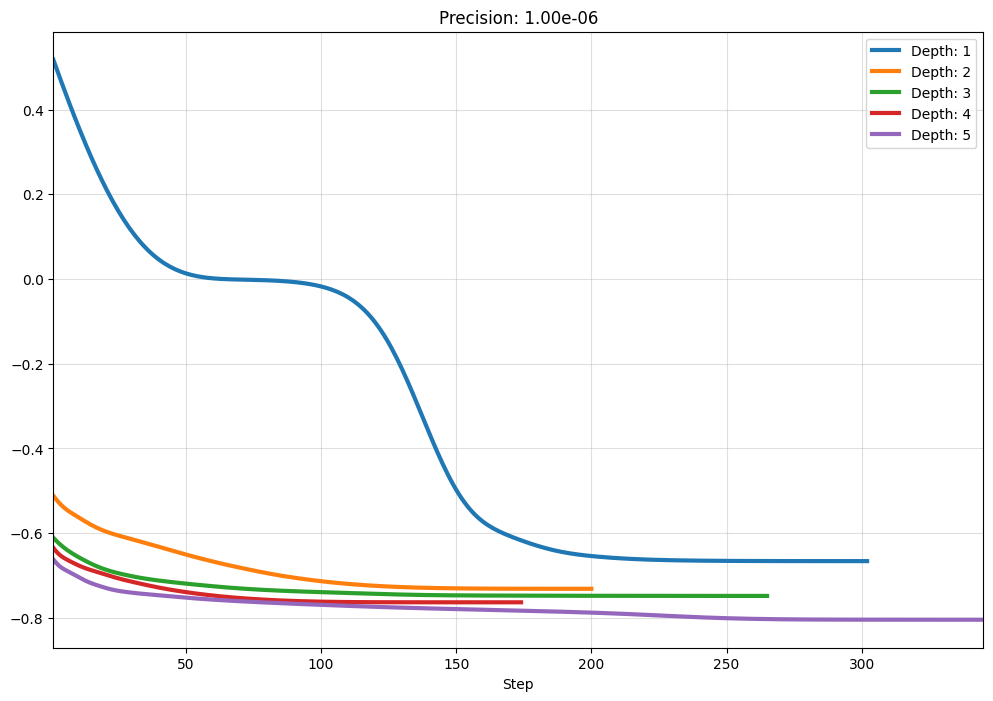

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

for depth in range(adapt.depth):
    costs = adapt.all_costs[depth]
    evals = adapt.all_evals[depth]
    ax.plot(range(1, evals + 1), costs, lw=3, label=f"Depth: {depth + 1}")

ax.set_title(f"Precision: {adapt.prec:.2e}")
ax.set_xlim(1, max(adapt.all_evals))
ax.set_xlabel("Step")
ax.grid(alpha=0.4)
ax.legend()


---
# DQAOA

In [ ]:
class DQAOA:
    def __init__(
        self,
        Jij,
        depth,
        steps,
        num_iterations,
        num_constants,
        alg="qaoa",
        prec=1e-6,
        optimizer="grad_descent",
        opt_kwargs={},
        device="default.qubit",
        num_core_err=20,
    ):
        self.Jij = Jij
        self.depth = depth
        self.steps = steps
        self.alg = alg
        self.prec = prec
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        self.device = device

        # How many times to run sub-QAOAs
        self.num_iterations = num_iterations
        # How many bits to ignore in sub-QAOAs
        self.num_constants = num_constants
        # Length of global bit string
        self.size = self.Jij.shape[0]
        # Length of sub-bit string/size (number of qubits) of sub-QAOA
        self.subsize = self.size - self.num_constants
        # How many cores to use
        self.num_cores = self.num_constants + 1
        # Just in case, we don't wanna slam the computer with too many cores
        if self.num_cores > num_core_err:
            raise Exception(
                f"Number of cores to be used is {self.num_cores} which is greater than"
                f"the limit {num_core_err}. If this is ok, set `num_core_err` to a"
                "greater number than `num_constants` + 1."
            )

        # How many sub-qaoa iterations we've done
        self.subiter_count = 0
        # Global bitstring
        self.global_bs = list(numpy.random.choice([0, 1], self.size))
        self.init_global_bs = self.global_bs
        # self.global_bs = [0] * self.size
        self.global_energy = self.calculate_energy(self.global_bs)
        # Histories
        self.energy_history = [self.global_energy]
        self.bs_history = [self.global_bs]
        self.iter_history = [0]
        # self.total_energy_history = [self.global_energy]
        # self.total_bs_history = [self.global_bs]

    def create_sub_alg(self, Jij):
        match self.alg:
            case "qaoa":
                Alg = QAOA
            case "maqaoa":
                Alg = MAQAOA
            case "xqaoa":
                Alg = XQAOA

        alg = Alg(
            Jij=Jij,
            depth=self.depth,
            steps=self.steps,
            prec=self.prec,
            optimizer=self.optimizer,
            opt_kwargs=self.opt_kwargs,
            device=self.device,
        )
        return alg

    def get_most_likely_bitstrings(self, alg):
        alg.optimize()
        probs_dict = alg.get_probs(as_dict=True)
        # Gets the highest probability bit string
        top_bs = sorted(probs_dict.items(), reverse=True, key=lambda val: val[1])[0][0]

        return top_bs, swap(top_bs)

    def compare_energies(self, bit_inds, new_bits, iter_ind):
        new_energies, new_bitstrings, new_iters = [], [], []
        for bit_ind, bit in zip(bit_inds, new_bits):
            new_bs = self.global_bs[:bit_ind] + [int(bit)] + self.global_bs[bit_ind + 1 :]
            new_energy = self.calculate_energy(new_bs)

            if new_energy < self.global_energy:
                self.global_energy = new_energy
                old_bs_str = "".join([str(b) for b in self.global_bs])
                new_bs_str = "".join([str(b) for b in new_bs])
                # self.global_bs = new_bs
                print(f"    Global: {old_bs_str} --> {new_bs_str}")
                new_energies.append(self.global_energy)
                new_bitstrings.append(new_bs)
                new_iters.append(iter_ind)
                # self.energy_history.append(self.global_energy)
                # self.bs_history.append(self.global_bs)
                # self.iter_history.append(iter_ind)

        return new_energies, new_bitstrings, new_iters

    def calculate_energy(self, bitstring):
        s = [2 * bit - 1 for bit in bitstring]
        return s @ self.Jij @ s

    def do_iteration(self, iter_bits, iter_ind):
        # Create smaller weight matrix without the constant bits
        reduced_Jij = self.Jij[iter_bits][:, iter_bits]
        # Create algorithm class with said weightmatrix
        alg = self.create_sub_alg(Jij=reduced_Jij)
        # Run algorithm and find most likely bitstrings (there's 2)
        bitstrings = self.get_most_likely_bitstrings(alg=alg)
        # Randomly choose one of them (for now)
        bitstring = choice(bitstrings)

        if self.print_it:
            sub_bs_str = ["x"] * self.size
            for bit_ind, bit in zip(iter_bits, bitstring):
                sub_bs_str[bit_ind] = bit
            sorted_inds = numpy.argsort(iter_bits)
            print(
                f"  Bitstring to check: {''.join(sub_bs_str)} | "
                f"{''.join(numpy.array(list(bitstring))[sorted_inds])} -- "
                f"{', '.join([str(x) for x in iter_bits[sorted_inds]])}"
            )

        # Replace each bit with the sub-QAOA solution and check energy
        new_energies, new_bitstrings, new_iters = self.compare_energies(
            bit_inds=iter_bits, new_bits=bitstring, iter_ind=iter_ind
        )

        return new_energies, new_bitstrings, new_iters

    def create_sub_bits(self):
        sub_bits = numpy.empty((self.num_iterations, self.num_cores, self.subsize), dtype=int)
        # init_bits = sliding_window_view(numpy.arange(self.size), window_shape=self.subsize)
        for iter_ind in range(self.num_iterations):
            for core_ind in range(self.num_cores):
                bit_choice = numpy.random.choice(range(self.size), self.subsize, replace=False)
                sub_bits[iter_ind][core_ind] = bit_choice

        return sub_bits

    def run_pool(self, print_it=False):
        self.sub_bits = self.create_sub_bits()
        self.print_it = print_it

        for iter_ind, iter_bits in enumerate(self.sub_bits):
            if self.print_it:
                if iter_ind:
                    print()
                print(
                    f"  -----   {iter_ind + 1}/{self.num_iterations}   -----  ",
                    flush=True,
                )
            with Pool(self.num_cores) as pool:
                new_data = pool.starmap(
                    self.do_iteration, zip(iter_bits, [iter_ind] * self.num_cores)
                )
                new_energies = [n for new_datum in new_data for n in new_datum[0]]
                new_bitstrings = [n for new_datum in new_data for n in new_datum[1]]
                new_iters = [n for new_datum in new_data for n in new_datum[2]]

                if new_energies:
                    min_ind = np.argmin(new_energies)

                    if new_energies[min_ind] < self.global_energy:
                        old_bitstring = self.global_bs
                        old_energy = self.global_energy
                        self.global_bs = new_bitstrings[min_ind]
                        self.global_energy = new_energies[min_ind]
                        self.energy_history.append(self.global_energy)
                        self.bs_history.append(self.global_bs)
                        self.iter_history.append(new_iters)

                        if self.print_it:
                            old_bs_str = "".join([str(x) for x in old_bitstring])
                            g_bs_str = "".join([str(x) for x in self.global_bs])
                            print(f"New bitstring: {old_bs_str} --> {g_bs_str}")
                            print(f"New energy: {old_energy:.4f} --> {self.global_energy}")

---
# WSQAOA

In [ ]:
class WSQAOA(VQA):
    """
    Warm start QAOA. There are more complicated variations of this algorithm but this
    one initializes the circuit with a continuous estimation of the solution via
    classical means. This then changes the form of the mixer Hamiltonian/layer.

    See https://arxiv.org/pdf/2009.10095.pdf.
    """

    def __init__(
        self,
        Jij,
        depth,
        steps,
        eps=0.5,
        prec=1e-6,
        optimizer="grad_descent",
        opt_kwargs={},
        device="default.qubit",
        bitflip_prob=0,
        method="COBYLA",
    ):
        super().__init__(
            Jij=Jij,
            depth=depth,
            steps=steps,
            prec=prec,
            optimizer=optimizer,
            opt_kwargs=opt_kwargs,
            device=device,
            bitflip_prob=bitflip_prob,
        )

        self.param_shapes = ((self.depth,), (self.depth,))

        self.eps = eps
        self.initial_guess = self.find_estimated_continuous_solns(method=method)
        # self.initial_guess = np.array([0.9, 0.9, 0.9, 0.1, 0.1, 0.1])
        self.get_angles()

    def find_estimated_continuous_solns(self, method):
        def func(x):
            energy = 0
            for i, j in product(range(self.N), repeat=2):
                energy += self.Jij[i, j] * (x[i] * x[j] - x[i])
            return energy

        self.x0 = np.random.uniform(0, 1, self.N)
        res = minimize(
            fun=func,
            x0=self.x0,
            bounds=[[0, 1]] * self.N,
            method="COBYLA",
        )
        return res.x

    def get_angles(self):
        self.thetas = []
        for ind, init_param in enumerate(self.initial_guess):
            if init_param <= self.eps:
                self.thetas.append(2 * asin(sqrt(self.eps)))
            elif init_param > 1 - self.eps:
                self.thetas.append(2 * asin(sqrt(1 - self.eps)))
            else:
                self.thetas.append(2 * asin(sqrt(init_param)))

    def circuit(self, *params):
        """
        Rewrite for different state initialization.
        """
        # Initialize with Hadamards
        for ind, theta in enumerate(self.thetas):
            qml.RY(theta, wires=ind)
        qml.Barrier()

        # Add layers
        qml.layer(self.layer, self.depth, *params)

    def layer(self, gamma, beta):
        # Create Pauli rotation gates
        for edge, weight in zip(self.edges, self.weights):
            qml.PauliRot(gamma * weight, "ZZ", wires=edge)
        qml.Barrier()
        for ind, theta in enumerate(self.thetas):
            qml.RY(-theta, wires=ind)
            qml.RZ(2 * beta, wires=ind)
            qml.RY(theta, wires=ind)
        qml.Barrier()